In [31]:
import numpy as np
import scipy as sc
import scipy.special as sp
import scipy.stats as ss
import pandas as pd
import math as ma
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import datetime
fontsize_axes = 18.0
fontsize_ticker = 16.0

# Mining pool risk analysis

Let $\pi_{\text{BTC}}$ be the bitcoin price in USD and $\pi_{\text{BTC}}$ be the number of bitcoin as a bounty for finding a new block. The reward is worth

$$b = n_{\text{BTC}}\cdot\pi_{\text{BTC}}$$

In [32]:
# r = requests.get('https://blockchain.info/ticker')
# quote  = dict(r.json())
n_BTC, π_BTC = 6.25, 36347.89
b = n_BTC * π_BTC
print('The BTC price is $' + str(π_BTC) )
print('The reward for finding a block amount to $' + str(b) )

The BTC price is $36347.89
The reward for finding a block amount to $227174.3125


The electricity consumption estimated by the Cambridge Bitcoin Electricity Consumption Index [CBECI](https://cbeci.org/) in TWh per year is converted into kWh par hour and denoted by $W$.

In [35]:
# Operational cost of the network
W =  95.6764 * 10**9 / 365.25 / 24

print('The network consumes ' + str(95.6764) + ' tWh per year')  
print('The network consumes ' + str(W) + ' kWh per hour') 

The network consumes 95.6764 tWh per year
The network consumes 10914487.793748574 kWh per hour


The time unit is the hour, The network finds 6 new blocks every hour. The number of blocks up to time $t$ is a Poisson process $(N_t)_{t\geq0}$ of intensity $\lambda = 6$.

In [36]:
# Intensity of the Poisson process
λ = 6
print('The time unit is the hour, the Poisson process intensity is λ = ' + str(λ))

The time unit is the hour, the Poisson process intensity is λ = 6


## Miner's risk analysis

Consider a miner with hahspower $p$. The miners join a mining pool that gives out $W\sim\text{Exp}(w = (1-f)qb)$ for every share that the miner finds. Recall that $f\in(0,1)$ is the manager's cut and $q\in(0,1)$ is the relative difficulty of finding a share compared to finding a proper solution.

The wealth of our miner is given by  

$$
R_t = u-c\cdot t+ \sum_{i = 1}^{\tilde{M}_t}W_i,
$$

where 

- $u$ is the initial reserves
- $c$ is the operational cost of mining
- $b$ the block finding reward
- $\tilde{M}_t$ is a Poisson process of intensity $\mu = p\lambda/q$ the number of shares found by the considered miner until $t\geq0$

$p\in(0,1/2)$ corresponds to the share of the network hash power owned by the miner. The operational cost is given by

$$
c = p\cdot W\cdot \pi_{\text{W}}, 
$$

where $\pi_{W}$ is the prices of one kWh of electricity. The net profit condition reads as 

$$
\mu w -  W\cdot \pi_{\text{W}}>0.
$$

Note that we retrieve the case of solo mining if we set $f = 0$ and $q=1$.

In [37]:
print('The net profit condition holds if the cost of electricity is lower than '
      + str(np.around(λ * b / W, decimals = 3))+
      ' when mining solo')

The net profit condition holds if the cost of electricity is lower than 0.125 when mining solo


The ruin time is defined by

$$
\tau_u = \inf\{t\geq0\text{ ; }R_t<0\}.
$$

The ruin probability up to time horizon $t\geq0$ is defined as 

$$
\psi(u,t) = \mathbb{P}(\tau_u \leq t).
$$

The ultimate ruin probability

$$
\psi(u) = \mathbb{P}(\tau_u < \infty)
$$

The miner surplus if ruin does not occur is given by
$$
V(u,t) = \mathbb{E}(R_t\mathbb{I}_{\tau_u>t}).
$$

The ruin probability and expected surplus up to an exponential time horizon $T\sim \text{Exp}(t)$ are denoted by

$$
\widehat{\psi}(u,t) = \mathbb{E}[\psi(u,T)],\text{ et } \widehat{V}(u,t) = \mathbb{E}[V(u,T)].
$$


1. The ruin probability up to an exponential time horizon is given by 
$$
\widehat{\psi}(u,t) = e^{\theta^{\ast} u}
$$
where $\theta^{\ast}$ is the solution of the equation
$$
-c_i\theta^{2}+\theta\left(\frac{1}{t}+\mu-\frac{c_i}{w}\right)+\frac{1}{wt} = 0.
$$
Write a function *ψ_T_miner(u, t, w, μ, c)* to calculate the ruin probability of a miner. Evaluate the ruin probability of this miner for $p = 0.01, pi_W = 0.09,t = 24, u = 10^6$ and the ruin probability of the same miner in minig pool for $f = 0.05$ and $q\in\{0.25, 0.5, 0.75\}$.

In [40]:
def ψ_T_miner(u, t, w, μ, c):
    Δ = (1/t +  μ - c / w) **2 + 4 * c / w / t
    rho_star = ((1/t + μ - c / w) + Δ**(1/2))/2/c 

    return(np.exp(-rho_star * u))

u, p, π_W, t, f =10**6, 0.01, 0.09, 24*7 , 0.05
c = π_W * W * p
qs = [0.25, 0.5, 0.75]
ψ_T_miner(u, t, b, λ * p, c), [ψ_T_miner(u, t, (1-f) * b * q, λ * p / q, c) for q in qs]  
# (0.04255134240050544, [0.00036277276735433744, 0.008740858761772208, 0.027072830152734928])

(0.04255134240050544,
 [0.00036277276735433744, 0.008740858761772208, 0.027072830152734928])

2. Plot three curves for the ruin probabilities associated to relative difficulty $q\in\{0.25, 0.5, 0.75\}$ and add a curve for the ruin probability of solo mining as a function of the initial reserves. We keep the values for the other parameters $p = 0.01, \pi_W = 0.09,t = 168$ (one week).

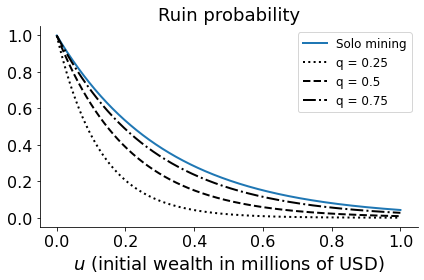

In [41]:
p, π_W, t, f =0.01, 0.09, 24*7 , 0.05
c = π_W * W * p
q_vec = [0.25, 0.5, 0.75]
u_vec = np.arange(100, 1000000, 100)

ψ_solo = [ψ_T_miner(u, t, b, λ*p, p * W * π_W) for u in u_vec]
plt.plot(u_vec *1e-6, ψ_solo,linewidth =2, label = "Solo mining")
linestyles = ['dotted', 'dashed', 'dashdot']
for k,q in enumerate(q_vec):
    ψ_pool = [ψ_T_miner(u, t, (1-f) * b * q, λ / q * p  , p * W * π_W) for u in u_vec]
    plt.plot(u_vec *1e-6, ψ_pool,linewidth =2, linestyle = linestyles[k], color = "k", label = "q = "+str(q))
plt.xlabel('$u$ (initial wealth in millions of USD)', fontsize = fontsize_axes)
plt.title('Ruin probability', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize = 12)
sns.despine()
plt.tight_layout()
plt.savefig('../../Figures/rp_miner_in_pool.pdf')

## Pool manager risk analysis

The wealth of the pool manager is given 
$$
R_t= u - \sum_{i=1}^{M_t} W_i +\sum_{j=1}^{N_t} B_j,\text{ }t\geq0.
$$

where 
- $(M_t)_{t\geq0}$ and $(N_t)_{t\geq0}$ are Poisson processes with intensity $\mu^\ast=\mu- \lambda$ and $\lambda$ corresponding to the number of shares submitted to the pool manager and the number of blocks found by the pool.
- $(W_i)_{i\geq0}$ and $(B_j)_{j\geq0}$ are two independent sequence of iid exponentially distributed random variables with mean $w$ and $b^\ast = b-w$

The ruin probability is given by 
$$
    \widehat{\psi}(u,t) = (1-Rw)  e^{-R u},\;u\ge 0,
$$
where $R$ is the (unique) solution with positive real part of 
$$
    -(t^{-1}+\lambda+\mu^\ast)+\lambda(1+b^\ast r)^{-1}+\mu^\ast(1-wr)^{-1}=0.
$$

3. Write a function *ψ_pool_T(u, t, b, λ, q, f)* to compute the ruin probability of the pool manager. Compute the ruin probability for a pool manager that coordinate a mining pool with haspower $p = 0.1$, management fee $f = 0.05$, initial reserves $u = 10^6$ and relative difficulty $q\in\{0.25, 0.5, 0.75\}$. The time horizon is $t = 168$ (one week).

In [20]:
# pool manager ruin probability
def ψ_pool_T(u, t, b, λ, q, f):
    μ = λ / q
    μstar = μ - λ
    w = b * q * (1 - f)
    bstar = b - w
    g = 1/t + μstar + λ
    α, β,γ = g*bstar * w, μstar * bstar - λ * w - g*(bstar - w) , -1/t
    Δ = β**2 - 4 * α * γ
    Rstar = (-β + np.sqrt(Δ))/ 2/α
    return((1-Rstar * w) *np.exp(-Rstar*u))

# Evaluation
u, t, f, p = 10**6, 24*7, 0.05, 0.1
qs = [0.25, 0.5, 0.75]
[ψ_pool_T(u, t, b, p*λ, q, f) for q in qs]

[0.47362836135109865, 0.3755947340706629, 0.22076144078619261]

4. Plot the ruin probability as a function of $u$ of the pool manager for $p = 0.1, f = 0.05$. The graph includes three curves associated to different relative diffficulty $q\in\{0.25, 0.5, 0.75\}$. The time horizon is $t = 168$ (one week). 

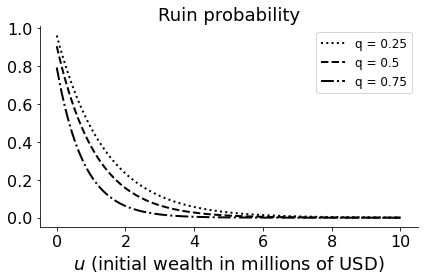

In [25]:
t, f, p = 24*7, 0.05, 0.1
qs = [0.25, 0.5, 0.75]
u_vec = np.arange(0, 10000000, 1000)
linestyles = ['dotted', 'dashed', 'dashdot']

for k,q in enumerate(qs):
    ψ_manager = [ψ_pool_T(u, t, b, λ * p, q, f) for u in u_vec]
    plt.plot(u_vec*1e-6, ψ_manager,linewidth =2, linestyle = linestyles[k], color = "k", label = "q = "+str(q))
plt.xlabel('$u$ (initial wealth in millions of USD)', fontsize = fontsize_axes)
plt.title('Ruin probability', fontsize = fontsize_axes)
plt.tick_params(labelsize=fontsize_ticker)
plt.legend(fontsize = 12)
sns.despine()
plt.tight_layout()
plt.savefig('../../Figures/rp_pool_manager.pdf')

### Risk on centralization

The expected wealth given that ruin did not occur is given by
$$
    \widehat{V}(u,t) = (1 - Rw)[w-t(\lambda b^\ast-\mu^\ast w)] e^{-R u}+u+t(\lambda b^\ast-\mu^\ast w),
$$
where $R$ is the (unique) solution with positive real part of 
$$
    -(t^{-1}+\lambda+\mu^\ast)+\lambda(1+b^\ast r)^{-1}+\mu^\ast(1-wr)^{-1}=0.
$$

5. Write a function *V_pool_T(u, t, b, λ, q, f)* to compute the expected wealth of the pool manager. Compute the expected wealth for $p = 0.1, f = 0.05, u = 10^6$ and $q\in\{0.25, 0.5, 0.75\}$ 

In [22]:
def V_pool_T(u, t, b, λ, q, f):
    μ = λ / q
    μstar = μ - λ
    w = b * q * (1 - f)
    bstar = b - w
    g = 1/t + μstar + λ
    α, β,γ = g*bstar * w, μstar * bstar - λ * w - g*(bstar - w) , -1/t
    Δ = β**2 - 4 * α * γ
    Rstar = (-β + np.sqrt(Δ))/ 2/α

    return((1-Rstar * w) * (w - t*(λ * bstar - μstar * w)) * np.exp(-Rstar*u)  + u + t*(λ * bstar - μstar*w))

# Evaluation
u, t, f, p = 10**6, 24*7, 0.05, 0.1
qs = [0.25, 0.5, 0.75]
[V_pool_T(u, t, b, p*λ, q, f) for q in qs]

[1628227.7971284739, 1755447.739383023, 1927928.6607556434]

We use our function to study the expected profit as a function of the pool management fee $f$ and the pool total haspower $p$

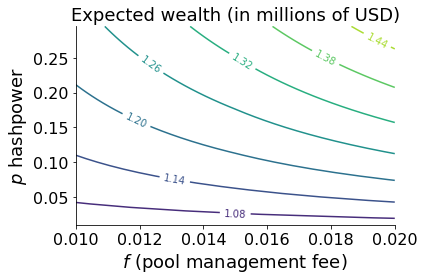

In [49]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

u, t, p, λ, q  = 10**6, 24*7, 0.1, 6, 0.25
f = np.arange(0.01, 0.025, 0.005)
p = np.arange(0.01, 0.3, 0.005)
F, P = np.meshgrid(f, p)
V = V_pool_T(u, t, b, λ * P, q, F) *1e-6
fig, ax = plt.subplots()
CS = ax.contour(F, P, V)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Expected wealth (in millions of USD)', fontsize = fontsize_axes)
# plt.title('Expected profit (in millions of USD)', fontsize = fontsize_axes)
ax.tick_params(labelsize=fontsize_ticker)
ax.set_xlabel('$f$ (pool management fee)', fontsize = fontsize_axes)
ax.set_ylabel('$p$ hashpower', fontsize = fontsize_axes)
sns.despine()
plt.tight_layout()
plt.savefig('../../Figures/level_plot_V_pool_manager_p_f.pdf')

A larger pool can maintain a given level of profit while providing a smaller fee and therefore attract more miners and grows even more. 

To defend itself against this situation a smaller pool may act on the magnitude of the risk transfer. Let us have a look at the expected profit as a function of $f$ and $q$ for 
- mining pool 1 with hashpower $p_1=0.05$
- mining pool 2 with haspower $p_2 = 0.2$

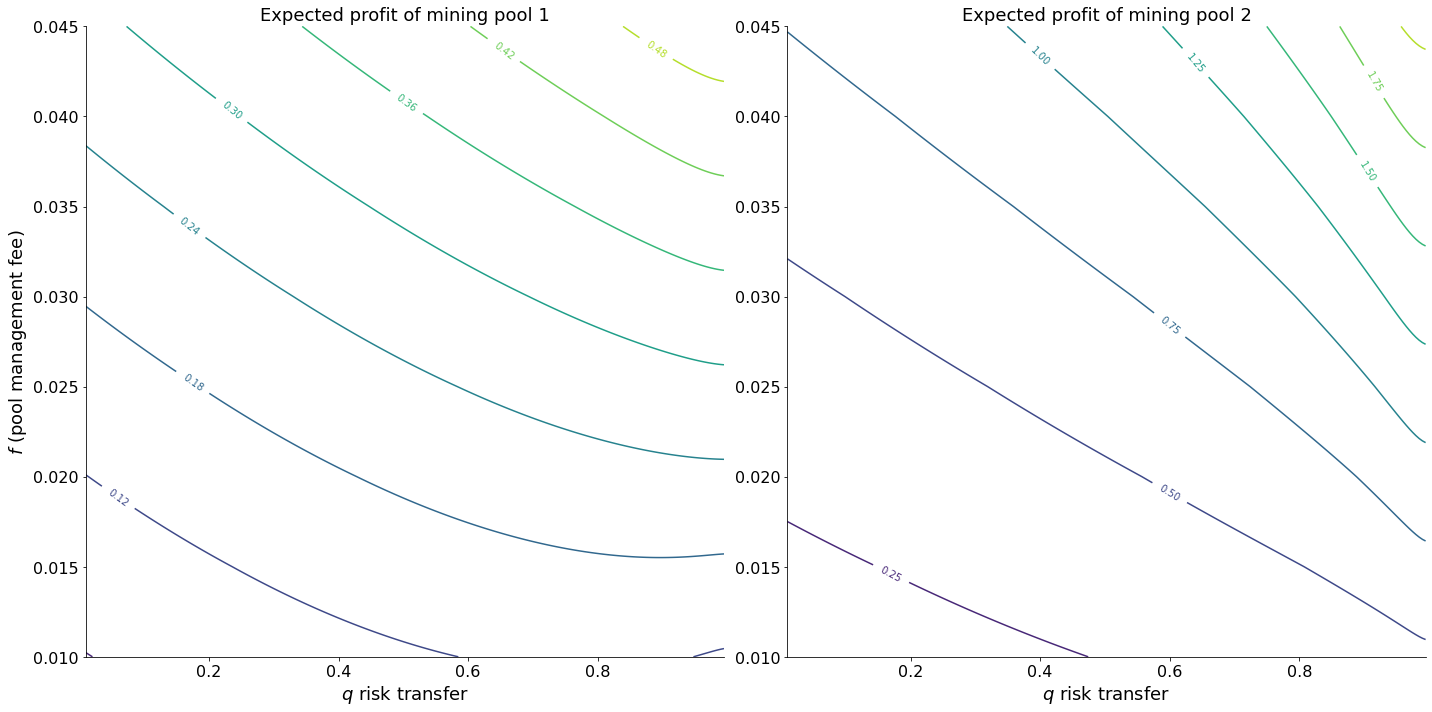

In [47]:
u, t, λ  = 10**6, 24*7, 6
p1, p2 = 0.05, 0.2 
f = np.arange(0.01, 0.05, 0.005)
q = np.arange(0.01, 1, 0.005)
Q , F = np.meshgrid(q, f)
V = [V_pool_T(u, t, b, λ * p1, Q, F)  - u, V_pool_T(u, t, b, λ * p2, Q, F)  - u]
fig, ax = plt.subplots(1, 2, figsize=(20,10))
# fig.tight_layout()

for k in range(2): 
    CS = ax[k].contour(Q, F, V[k]*1e-6)
    ax[k].clabel(CS, inline=True, fontsize=10)
    ax[k].set_title('Expected profit of mining pool '+str(k+1), fontsize = fontsize_axes)
    ax[k].tick_params(labelsize=fontsize_ticker)
    ax[0].set_ylabel('$f$ (pool management fee)', fontsize = fontsize_axes)
    ax[k].set_xlabel('$q$ risk transfer', fontsize = fontsize_axes)
sns.despine()
fig.tight_layout()
plt.savefig('../../Figures/level_plots_V_pool_manager_q_f.pdf')

- The expected profit under ruin of a smaller mining pool is less sensitive to a smaller value of $q$ where a bigger mining pool might have to increase the fee to decrease $q$ while maintaining the same expected profit. 

The fact that miner are heterogeneous in terms of risk aversion and that mining pool will offer various risk coverage (by tuning the value of $q$) depending on their hashpower could make decentralization prevail. The strategic behaviors of the different player require a game theoretic approach. 
